<p>Aim is to produce some initial graphs giving indications of sentiment with very little analysis, including:
<ul><li>The top x emojis associated with each airline (and their sentiment)</li>
    <li>Proportion of tweets to each airline that include an emoji</li>
    <li>Mean sentiment for each airline using the sentiment of the emojis tweeted at them</li>
</ul>
Also need to read up on the paper Calum sent.


</p>

<p>Import emosent package and read csv file</p>

In [79]:
from emosent import get_emoji_sentiment_rank
import pandas
import matplotlib
import csv
from emoji import UNICODE_EMOJI

# open csv file
tweets = []
with open('Tweets.csv', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',', quoting=csv.QUOTE_MINIMAL)
    next(reader)
    for row in reader:
        filtered_row = [row[5], row[10]]
        tweets.append(filtered_row)
        

#dataframe = pandas.read_csv("Tweets.csv")
#dataframe = dataframe[["airline", "text"]]

<p>Function to check if character is an emoji </p>

In [80]:
def isEmoji(character):
    try:
        # if character can be found by emosent module return true
        get_emoji_sentiment_rank(character)
        return True
    except KeyError:
        return False

<p>2D dictionary to store Tweet data for each airline</p>

In [81]:
airlines = {}
for airline in ["Virgin America", "United", "Southwest","Delta", "US Airways", "American"]:
    airlines[airline] = {"emojis":{},
                          "number_tweets":0,
                          "number_emoji_tweets":0,
                          "sentiment_sum":0}

<p>Iterate through tweets to count number of emojis per tweet, get sentiment data and sum this</p>

In [82]:
for tweet in tweets:
    airline = tweet[0]
    # update overall tweet_count for airline
    airlines[airline]["number_tweets"] += 1
    emojis = {}
    for character in tweet[1]:
        if isEmoji(character):
            if character in emojis:
                emojis[character] += 1
            else:
                emojis[character] = 1
    if emojis:
        # update emoji_tweet counter for this airline
        airlines[airline]["number_emoji_tweets"] += 1
        emoji_sentiment_in_tweet = 0
        num_emojis_in_tweet = 0
        for emoji in emojis: 
            # multiply sentiment by number occurrences
            emoji_sentiment_in_tweet += emojis[emoji] * get_emoji_sentiment_rank(emoji)['sentiment_score']
            num_emojis_in_tweet += emojis[emoji]
            
            # add to dictionary of emojis tweeted at the airline
            if emoji in airlines[airline]["emojis"]:
                airlines[airline]["emojis"][emoji] += 1
            else:
                airlines[airline]["emojis"][emoji] = 1
                
        # average out by number of emojis
        emoji_sentiment_in_tweet = emoji_sentiment_in_tweet / num_emojis_in_tweet
        airlines[airline]["sentiment_sum"] += emoji_sentiment_in_tweet

<p>Divide sentiment sum by number emoji tweets for each airline</p>

In [83]:
for airline in airlines:
    airlines[airline]['sentiment_sum'] = airlines[airline]['sentiment_sum'] / airlines[airline]['number_emoji_tweets']
    airlines[airline]['emoji_proportion'] = 100 * airlines[airline]['number_emoji_tweets'] / airlines[airline]['number_tweets']

<p>Output totals for each airline</p>

In [84]:
for airline in airlines:
    print(airline)
    for key in airlines[airline]:
        if key != "emojis":
            print("    ", key, airlines[airline][key])


Virgin America
     number_tweets 504
     number_emoji_tweets 39
     sentiment_sum 0.3945293706293706
     emoji_proportion 7.738095238095238
United
     number_tweets 3822
     number_emoji_tweets 62
     sentiment_sum 0.28134408602150535
     emoji_proportion 1.6221873364730508
Southwest
     number_tweets 2420
     number_emoji_tweets 119
     sentiment_sum 0.300231629061881
     emoji_proportion 4.917355371900826
Delta
     number_tweets 2222
     number_emoji_tweets 148
     sentiment_sum 0.2690212837837837
     emoji_proportion 6.660666066606661
US Airways
     number_tweets 2913
     number_emoji_tweets 60
     sentiment_sum 0.2015213888888889
     emoji_proportion 2.059732234809475
American
     number_tweets 2759
     number_emoji_tweets 63
     sentiment_sum 0.19368439153439154
     emoji_proportion 2.2834360275462124


<p>Format dict to dataframe - extremely messy method</p>

In [97]:
num_tweets = []
num_em_tweets = []
sentiments = []
proportion = []
for airline in airlines:
    num_tweets.append(airlines[airline]['number_tweets'])
    num_em_tweets.append(airlines[airline]['number_emoji_tweets'])
    sentiments.append(airlines[airline]['sentiment_sum'])
    proportion.append(airlines[airline]['emoji_proportion'])
trimmed = {'Airline' : list(airlines.keys()), 'number of tweets to airline':num_tweets,'number of tweets with emojis':num_em_tweets, 'airline sentiment':sentiments, 'proportion of tweets with emojis':proportion}
df = pandas.DataFrame(data=trimmed)
df

,Airline,number of tweets to airline,number of tweets with emojis,airline sentiment,proportion of tweets with emojis
0,Virgin America,504,39,0.394529,7.738095
1,United,3822,62,0.281344,1.622187
2,Southwest,2420,119,0.300232,4.917355
3,Delta,2222,148,0.269021,6.660666
4,US Airways,2913,60,0.201521,2.059732
5,American,2759,63,0.193684,2.283436


<p>Chart showing proportion of Tweets at each airline that include emojis</p>

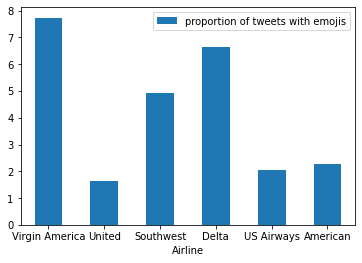

In [98]:
df.sort_values(by=['proportion of tweets with emojis'])
proportion_ax = df.plot.bar(x='Airline', y='proportion of tweets with emojis', rot=0)

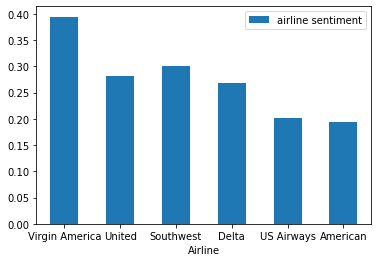

In [96]:
df.sort_values(by=['airline sentiment'])
sentiment_ax = df.plot.bar(x='Airline', y='airline sentiment', rot=0)

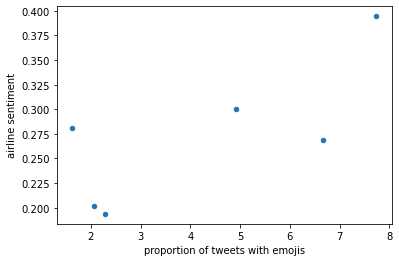

In [99]:
sentiment_emoji_ax = df.plot.scatter(x='proportion of tweets with emojis', y='airline sentiment')